# Příklad zpracování sktrukturovaných dat

Co se naučíme:
- Vyzkoušíme si predikci pravděpodobnosti pro reálná data.  
    - "S jakou pravděpodobnsotí má pacient onemocnění srdce?"
    - (Pravděpodobnost je buď v intervalu 0-1 nebo v procentech. Pravděpodobnost 1 odpovídá 100%)
- Implementujeme třídy v pythonu
- Tentokrát použijeme knihovnu Lightning https://lightning.ai/docs/overview/getting-started
- Budeme měřit trénovací a validační chybu
    - Trénovací data model "viděl" během trénování
    - Validační data model nikdy neviděl


In [1]:
# Nainstalujeme chybějící knihovny (může trvat déle)
%pip install pandas #==2.0.3
%pip install ipympl
%pip install lightning

In [2]:
# Import potřebných knihoven ------------------------------------------------

# Knihovny pro zobrazování a interaktivitu
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
from ipywidgets import widgets, interact
import ipympl
from tqdm import tqdm
import prettytable as pt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display as IPydisplay

# Práce s daty
import urllib.request, json
import pandas as pd
import numpy as np

# Trénování
import torch
import lightning as L

# Můžeme se podívat na verze knihoven
print("Version of pandas: " + pd.__version__)
print("Version of prettytable: " + pt.__version__)
print("Version of numpy: " + np.__version__)
print("Version of torch: " + torch.__version__)
print("Version of lightning: " + L.__version__)

Version of pandas: 2.2.2
Version of prettytable: 3.16.0
Version of numpy: 2.0.2
Version of torch: 2.8.0+cu126
Version of lightning: 2.5.3


### Pomocné funkce - nebudeme zkoumat

In [3]:
def print_data_sample(dataframe, patient_index, data_info):

    datarow = dataframe.iloc[patient_index]
    table = pt.PrettyTable()
    table.field_names = ["Feture Name", "Description", "Value for patient number " + str(patient_index)  ]

    for i, feature in enumerate(data_info):
        if data_info[feature]["type"] == "numerical" or feature == "thal":
            table.add_row([feature, data_info[feature]["description"], datarow[i]])

        elif data_info[feature]["type"] == "categorical":
            table.add_row([feature, data_info[feature]["description"], data_info[feature]["encoding"][datarow[i]]])

    print(table)

# Zobrazovač natrénovaného modelu s daty
def display_nonlinear_function_torch(input_df_trn, input_df_val, target_df_trn, target_df_val, model=None):

    plt.close()

    # concatenate dataframes
    input_df = pd.concat([input_df_trn, input_df_val])
    target_df = pd.concat([target_df_trn, target_df_val])

    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlim(min(input_df)-1, max(input_df)+1)
    plt.ylim(min(target_df)-1, max(target_df)+1)

    if model:
        inputs_mean = torch.Tensor(input_df).mean().item()
        inputs_std = torch.Tensor(input_df).std().item()

        x = np.linspace(min(input_df)-1, max(input_df)+1, 100)
        x_tensor = (torch.Tensor(x).unsqueeze(1) - inputs_mean) / inputs_std
        y = model(x_tensor).cpu().detach().numpy()
        plt.plot(x, y)


    for x_val, y_label in zip(input_df_trn, target_df_trn):

        if model:
            x_val_tensor = (torch.Tensor([x_val]).unsqueeze(1) - inputs_mean) / inputs_std
            y_val = model(x_val_tensor).item()

            plt.plot([x_val, x_val], [y_val, y_label], color='blue', linestyle='dotted', markersize=0)
        plt.plot(x_val, y_label, marker='o', markersize=5, color='blue', alpha=0.2)

    for x_val, y_label in zip(input_df_val, target_df_val):
        if model:
            x_val_tensor = (torch.Tensor([x_val]).unsqueeze(1) - inputs_mean) / inputs_std
            y_val = model(x_val_tensor).item()
            plt.plot([x_val, x_val], [y_val, y_label], color='red', linestyle='dotted', markersize=0)

        plt.plot(x_val, y_label, marker='o', markersize=5, color='red', alpha=0.5)

    plt.xlabel('feature')
    plt.ylabel('pravděpodobnost nemoci')

    plt.grid(True)
    plt.gcf().set_size_inches(10, 6)
    plt.show()

def print_error_table(models):

    table = pt.PrettyTable()
    table.field_names = ["Model", "Training error", "Training error %", "Validation error", "Validation error %"]
    for model in models:
        table.add_row([model, models[model][0], models[model][0]*100, models[model][1], models[model][1]*100])
    print(table)

def display_two_feature_function(features, dataframe_trn, dataframe_val):
    plt.close()
    fig = plt.figure()
    axtrn = fig.add_subplot(121, projection='3d')
    axval = fig.add_subplot(122, projection='3d')

    for ax, title, dataframe in zip([axtrn, axval], ["Training data", "Validation data"], [dataframe_trn, dataframe_val]):
        ax.scatter(dataframe[features[0]],
                   dataframe[features[1]],
                   dataframe['target'], cmap='jet', c=dataframe['target'])
        ax.set_title(title)
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel('likelihood of heart disease')

    plt.show()

def display_two_feature_model(model):
    # Nachystáme si rozsah možných hodnot pro věk a cp
    grid_age = np.arange(0, 110, 1)
    grid_cp = np.arange(0, 5, 1)

    # pustíme předikce pro všechny kombinace věků a cp a sledujeme průběh predikce pomocí tqdm
    possible_ages = []
    possible_cps = []
    predictions = []

    for age in grid_age:
        for cp in grid_cp:
            possible_ages.append(age)
            possible_cps.append(cp)
            input_age = g_agepain_dataset_trn.normalize_age(age)
            input_cp = g_agepain_dataset_trn.one_hot_encode_cp(cp)
            input_data = torch.cat((input_age, input_cp))
            predictions.append(model(input_data).item())

    # Vykreslíme si predikce
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')

    from scipy.interpolate import griddata
    # připravíme si mřížku bodů pro vykreslení
    grid_x, grid_y = np.mgrid[0:4:100j, 0:100:100j]
    grid_z = griddata((possible_cps, possible_ages), predictions, (grid_x, grid_y), method='cubic', fill_value=0)

    ax.plot_surface(grid_x, grid_y, grid_z, cmap='jet',rstride=1, cstride=1,
                        linewidth=0, antialiased=False, shade=False)
    ax.set_xlabel('chest pain type')
    ax.set_ylabel('age')

    ax2d = fig.add_subplot(122)
    ax2d.contourf(grid_x, grid_y, grid_z, cmap='jet')
    ax2d.set_xlabel('chest pain type')
    ax2d.set_ylabel('age')
    plt.show()

from graphviz import Digraph
def display_age_pain_model():
    dot = Digraph(comment='LModel Detailed Architecture')
    dot.attr(rankdir='LR')
    dot.attr(size='8,8')
    dot.attr(ratio='fill')
    input_labels = ['Age','CP: Type 0','CP: Type 1','CP: Type 2','CP: Type 3','CP: Type 4']
    with dot.subgraph(name='cluster_input') as c:
        c.attr(label='Input Layer')
        for i in range(6): # Corrected range to 6 for all inputs
            dot.node(f'input_{i}', input_labels[i])
    for i in range(32):
        dot.node(f'hidden_{i}', f'ReLU()')
    dot.node('output', 'Sigmoid()')

    for i in range(6): # Connect all 6 inputs
        for j in range(32):
            dot.edge(f'input_{i}', f'hidden_{j}')
    for i in range(32):
        dot.edge(f'hidden_{i}', 'output')
    return dot

# Dataset
- Možina trénovacích dat, nejlépe i s labely
- Na internetu existuje spousta veřejně dostupných datasetů různých druhů
- Stáhneme si veřejně dostupný dataset onemocnění srdce:
Spracujeme data pomocí pandas.DataFrame - dokumentace zde: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [4]:
# Stáhneme data
g_dataframe = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

# Jak jsou data uložena?
g_dataframe.head() # zobrazí prvních 5 řádků

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


# Co tato čísla znamenají?
- Každý vzorek dat (tj. pacient) obsahuje různé typy featur - věk, pohlaví, typ bolesti...
- Každá featura může nabývat různých hodnot. Kategorické hodnoty, např. typ bolesti (cp), jsou kódované předem zvoleným číslem kategorie. Např. typ bolesti 'typical angina' je v datasetu kódován číslem 2.
- Některé featury jsou přirozeně číselného charakteru - např. krevní tlak (trestbps).
- Kódování (význam čísel) pro tento dataset lze dohledat v dokumentaci k datasetu. https://archive.ics.uci.edu/ml/datasets/heart+Disease


In [5]:
# Kódování kategorií známe z dokumentace k datasetu. Číselná hodnota odpovídá pořadí v seznamu.

with urllib.request.urlopen("https://raw.githubusercontent.com/Travnickt3d/FITLS/main/2024/dataset_info.json") as url:
    g_data_info = json.load(url)

# Vytištění vzorku po dekódování pomocí slovníku s informacemi - změníme parametr patient_index pro zobrazení jiného pacienta
for i in range(3):
    print_data_sample(g_dataframe, i, g_data_info)
    print("\n")

+-------------+------------------------------------------------------------+------------------------------+
| Feture Name |                        Description                         |  Value for patient number 0  |
+-------------+------------------------------------------------------------+------------------------------+
|     age     |                        age in years                        |              63              |
|     sex     |                       biological sex                       |             Male             |
|      cp     |              Chest pain type (0, 1, 2, 3, 4)               |        typical angina        |
|   trestbps  |             Resting blood pressure (in mm Hg)              |             145              |
|     chol    |                    Cholesterol in mg/dl                    |             233              |
|     fbs     |              Fasting blood sugar in 120 mg/dl              |             Yes              |
|   restecg   |            R

/tmp/ipython-input-1596561758.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  table.add_row([feature, data_info[feature]["description"], datarow[i]])
/tmp/ipython-input-1596561758.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  table.add_row([feature, data_info[feature]["description"], data_info[feature]["encoding"][datarow[i]]])


# Trénovací a validační dataset
- Doteď jsme zkoumali pouze chybu na trénovacích datech. To je ale v praxi zavádějící - potřebujeme aby model fungoval i na reálných datech, která nikdy neviděl
- Rozdělíme si dostupná data na trénovací a validační množinu

In [6]:
# Validační množina bude 20 % dostupných dat
g_dataframe_val = g_dataframe.sample(frac=0.2, random_state=42000)

# Trénovací možnina bude zbytek
g_dataframe_trn = g_dataframe.drop(g_dataframe_val.index)

print(f"Training dataset size: {len(g_dataframe_trn)}")
print(f"Validation dataset size: {len(g_dataframe_val)}")

Training dataset size: 242
Validation dataset size: 61


# Výskyt nemoci v závislosti na věku?
- Lze predikovat pravděpodobnost výskytu nemoci jen v závislosti na věku?
- Je to dobrý nápad?
- Podívejme se na data:

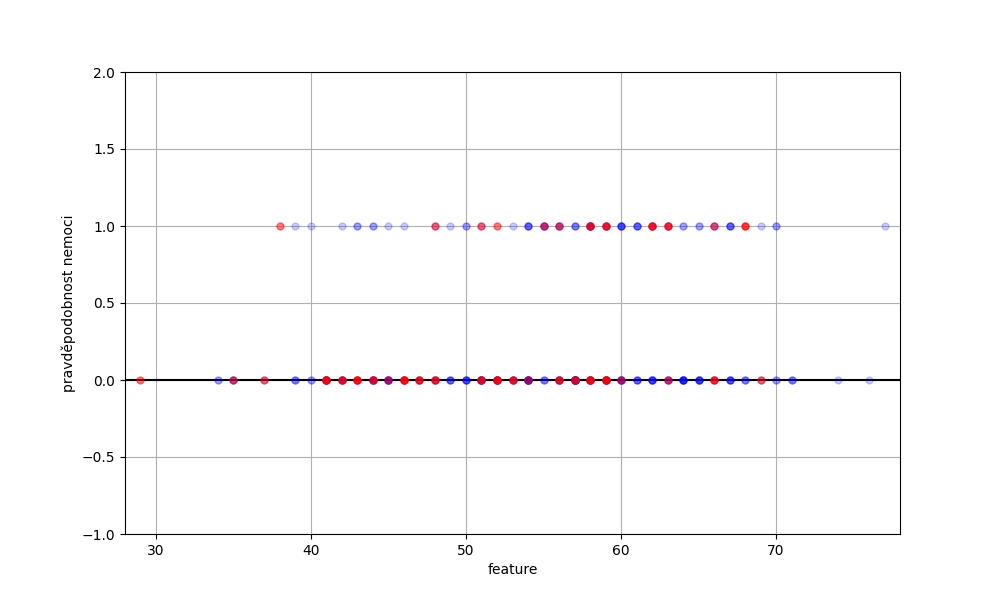

In [7]:
display_nonlinear_function_torch(g_dataframe_trn['age'],
                                 g_dataframe_val['age'],
                                 g_dataframe_trn['target'],
                                 g_dataframe_val['target'])

# Zkusme natrénovat model pomocí knihovny PyTorch

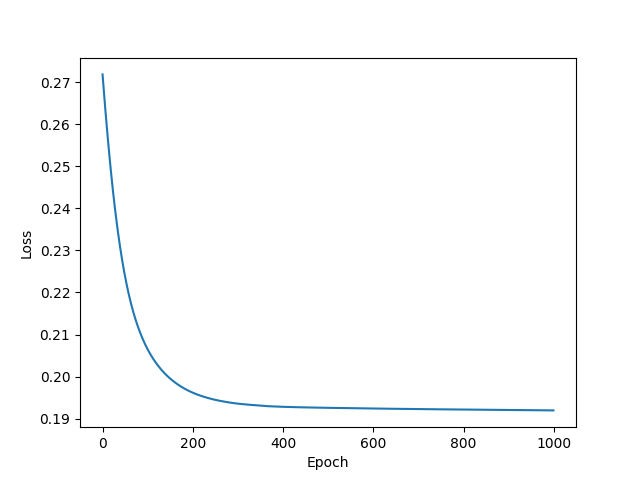

In [8]:
def train_one_feature(model, dataframe):

    # Nastavení trénování
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_function = torch.nn.MSELoss()

    # Konverze a normalizace vstupů
    inputs = torch.Tensor(dataframe['age'].values).unsqueeze(1)
    labels = torch.Tensor(dataframe['target'].values).unsqueeze(1)
    inputs_mean = inputs.mean().item()
    inputs_std = inputs.std().item()
    inputs = (inputs - inputs_mean) / inputs_std

    # Trénovací smyčka
    loss_history = []
    for t in range(1000):

        y_pred = model(inputs)

        loss = loss_function(y_pred, labels)
        loss_history.append(loss.item())

        print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
        IPydisplay.clear_output(wait=True)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_history

# Model pro predikci s jednou feature
g_model_one_feature = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)


# Trénování
g_one_feature_loss_h = train_one_feature(g_model_one_feature, g_dataframe_trn)

# Vykreslíme loss v průběhu trénování
plt.close()
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(g_one_feature_loss_h)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

# Jak dobrý je takový model?
- Zkusme porovnat průměrnou chybu modelu s úplně náhodným hádáním výsledku:
- Podívejme se také na vizualizaci modelu - vypadá rozumně?

+-------------------+--------------------+--------------------+--------------------+--------------------+
|       Model       |   Training error   |  Training error %  |  Validation error  | Validation error % |
+-------------------+--------------------+--------------------+--------------------+--------------------+
| One feature model | 0.3843514039989345 | 38.435140399893456 | 0.3771361450924248 | 37.71361450924248  |
|    Random guess   |        0.5         |        50.0        | 0.4918032786885246 | 49.18032786885246  |
+-------------------+--------------------+--------------------+--------------------+--------------------+


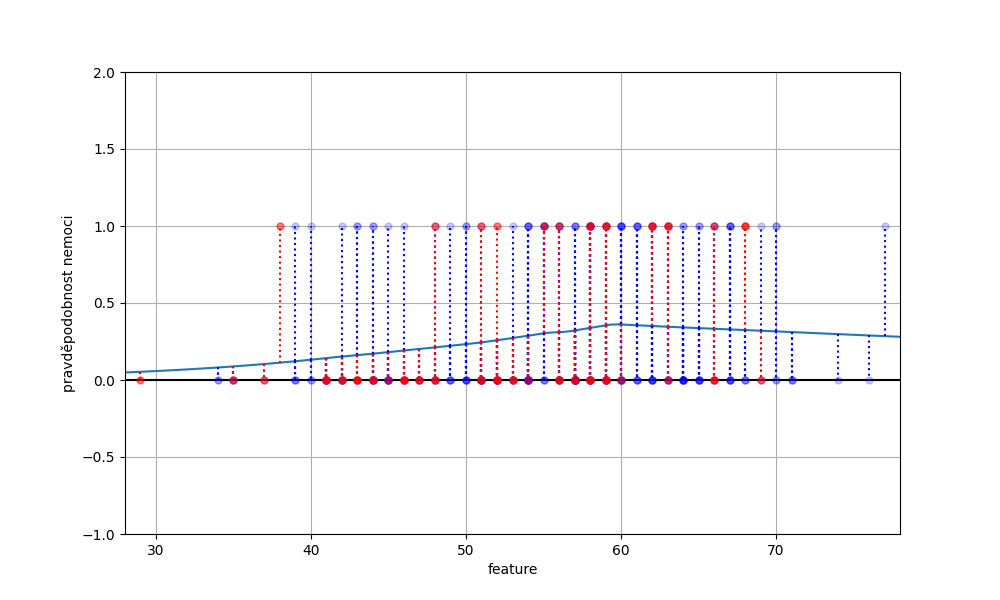

In [9]:
def one_feature_prediction(dataset, model):
    '''
    Funkce pro výpočet průměrné chyby predikce one feature modelu.
    '''
    inputs_mean = torch.Tensor(dataset['age'].values).mean().item()
    inputs_std = torch.Tensor(dataset['age'].values).std().item()

    error_value = 0
    largest_error = 0
    for i, row in dataset.iterrows():

        # normalizace
        input_tensor = (torch.Tensor([[row['age']]]) - inputs_mean) / inputs_std

        # predikce
        prediction = model(input_tensor).item()

        # chyba (absolutní rozdíl)
        error_value += abs(prediction - row['target'])

    return error_value / len(dataset)

def random_guess_error(dataset, normalize=False):
    '''
    Funkce pro výpočet při náhodném uhodnutí.
    '''
    error_value = 0
    for row in dataset.iloc:

        # Náhodně vybereme 0 nebo 1
        guess = np.random.randint(0, 2)
        # Chyba náhodného uhodnutí
        error_value += abs(guess - row['target'])
    return error_value / len(dataset)

# Spočítáme chybu na trénovacím setu
g_one_feature_err_trn = one_feature_prediction(g_dataframe_trn, g_model_one_feature)

# Spočítáme chybu na validačním setu
g_one_feature_err_val = one_feature_prediction(g_dataframe_val, g_model_one_feature)

# Spočítáme chybu náhodného hádání
g_random_err_trn = random_guess_error(dataset=g_dataframe_trn)
g_random_err_val = random_guess_error(dataset=g_dataframe_val)


# Uložíme si spočítané chyby do slovníku
g_model_errors = {"One feature model" : [g_one_feature_err_trn,
                                 g_one_feature_err_val],
                   "Random guess" : [g_random_err_trn,
                                     g_random_err_val]}

print_error_table(g_model_errors)

# Vykreslíme, co jsme to natrénovali
display_nonlinear_function_torch(g_dataframe_trn['age'],
                                 g_dataframe_val['age'],
                                 g_dataframe_trn['target'],
                                 g_dataframe_val['target'],
                                 g_model_one_feature)


# Potřebujeme další data...
- Model předpovídající nemoc jen z věku je velmi nepřesný (duh)
- Potřebujeme lépe rozlišit mladé lidi s nemocí a bez
- Zkusíme si přidat další feature - typ bolesti
    - Jak jsou na tom mladí lidé s bolestí typu 0-3?

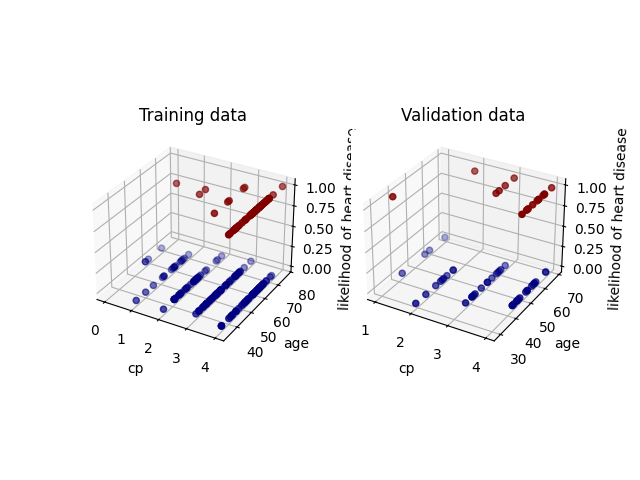

In [10]:
# Přidáme další proměnnou a zobrazíme si 3d graf
display_two_feature_function(['cp', 'age'], g_dataframe_trn, g_dataframe_val)

# Zkusíme natrénovat model na dvou featurách
- Použijeme tentokrát knihovnu pytorch lightning https://lightning.ai/docs/pytorch/stable/
- Musíme definovat model jako LightningModule
    - Vytvoříme si třídu LModel.
    - Třída je objekt, který má vlastní data (třeba self.model) a vlastní metody (třeba forward())
- AgePainDataset bude další třída. Obsahuje:
    - náš dataset,
    - metody pro zakódování a normalizaci dat,
    - metody pro vybírání vzorků z datasetu. (Vzorek je typu Tensor.)


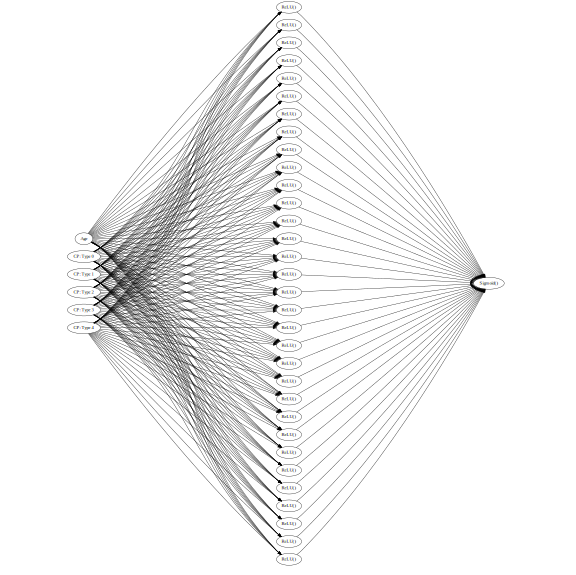

In [11]:
# Vytvoříme model, tentokrát jako lightening module
class LModel(L.LightningModule):
    """
    Třída pro definici modelu a přidružených metod.
    """
    def __init__(self, inputs, hidden_units, lr):
        super().__init__()

        # Samotný model je klasický sekvenční torch model
        self.model = torch.nn.Sequential(
            torch.nn.Linear(inputs, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, 1),
            torch.nn.Sigmoid()
        )

        self.lr = lr

        self.trn_loss_history = []
        self.val_loss_history = []

    def forward(self, x):
        '''
        Funkce pro předání dat do modelu. Zde pouhé zavolání model, jak už jsme viděli dříve...
        '''
        return self.model(x)

    def configure_optimizers(self):
        '''
        Nastavení trénovacího algoritmu je tentokrát zde v modulu.
        '''
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        '''
        Funkce pro jeden trénovací krok.
        '''
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        self.log("[TRAIN LOSS]", loss, prog_bar=True)
        self.trn_loss_history.append(loss.item())
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[TRAIN ERROR]", error, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        '''
        Funkce pro jeden validační krok.
        '''
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        self.val_loss_history.append(loss.item())
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[VAL LOSS]", loss, prog_bar=True)
        self.log("[VAL ERROR]", error, prog_bar=True)
        return loss

class AgePainDataset(torch.utils.data.Dataset):
    """
    Třída pro definici trénovacího a validačního datasetu.

    Obsahuje metody pro normalizace dat, kódování kategorických dat a získání jednoho vzorku.
    """
    def __init__(self, dataframe):
        self.dataframe = dataframe

        self.age_std = self.dataframe['age'].std()
        self.age_mean = self.dataframe['age'].mean()

    def __len__(self):
        return len(self.dataframe)

    def normalize_age(self, age):
        '''
        Číselnou featuru opět znormalizujeme aby se pohybovala kolem 0.
        '''
        return torch.tensor((age - self.age_mean) / self.age_std).unsqueeze(0).to(torch.float32)

    def one_hot_encode_cp(self, cp):
        '''
        Kategorickou featuru převedeme na one hot encoding.

        cp = 0 bude reprezentováno jako [1, 0, 0, 0, 0]
        cp = 1 bude reprezentováno jako [0, 1, 0, 0, 0]
        cp = 2 bude reprezentováno jako [0, 0, 1, 0, 0]
        ...
        '''
        one_hot = [0]*len(g_data_info["cp"]["encoding"])
        one_hot[cp] = 1
        return torch.tensor(one_hot).to(torch.float32)

    def __getitem__(self, idx):
        '''
        Funkce pro získání jednoho vzorku z datasetu.
        '''
        age = self.normalize_age(self.dataframe.iloc[idx]['age'])
        cp = self.dataframe.iloc[idx]['cp']
        cp = self.one_hot_encode_cp(cp)
        target = self.dataframe.iloc[idx]['target']
        return torch.cat((age, cp)), torch.tensor(target).unsqueeze(0).to(torch.float32)

graph = display_age_pain_model()
graph

# Trénovací smyčku teď zajistí "Trenér"
- Předtím jsme museli napsat smyčku sami, teď využijeme Trainer třídu z knihovny lightning

In [12]:
def train_two_fetures(model, dataset_trn, dataset_val, batch_size, epochs):

    # Vytvoření objektu "trenéra" z třídy L.Trainer
    trainer = L.Trainer(max_epochs=epochs)

    # Pomocné třídy na opakované vytahování batchů dat
    dataloader_trn = torch.utils.data.DataLoader(dataset_trn, batch_size=batch_size, drop_last=False, shuffle=True)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=61, drop_last=False)

    # Zde se teď skrývá trénovací smyčka
    trainer.fit(model=model,
                train_dataloaders=dataloader_trn,
                val_dataloaders=dataloader_val)


# Vytvoření objektů datasetů z naší třídy AgePainDataset
g_agepain_dataset_trn = AgePainDataset(g_dataframe_trn)
g_agepain_dataset_val = AgePainDataset(g_dataframe_val)

# Vytvoření modelu z naší třídy LModel
g_age_pain_model = LModel(inputs=6, hidden_units=32, lr=1e-3)

# Trénování modelu pro predikci s dvěmi features
train_two_fetures(g_age_pain_model, g_agepain_dataset_trn, g_agepain_dataset_val, batch_size=32, epochs=40)


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 257    | train
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=40` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


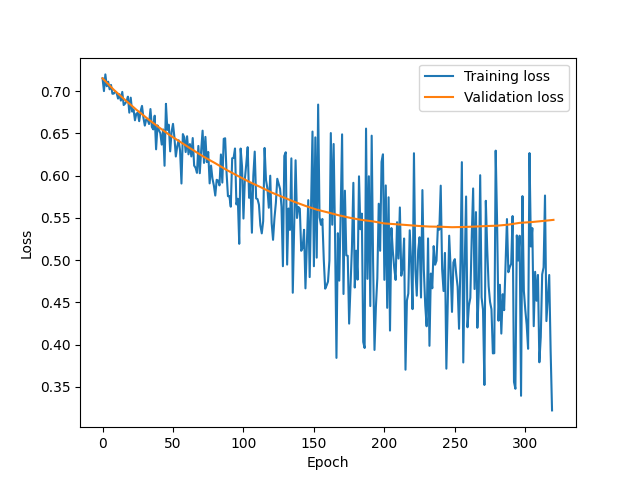

In [13]:
# Vykreslíme historii trénovacícho lossu
g_loss_history = g_age_pain_model.trn_loss_history
g_val_loss_history = g_age_pain_model.val_loss_history
val_x_axis_indices = np.linspace(0, len(g_loss_history), len(g_val_loss_history)).astype(int)

plt.close()
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(g_loss_history, label='Training loss')
ax.plot(val_x_axis_indices, g_val_loss_history, label='Validation loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()



# Natrénovaný model - dvě featury
- Porovnáme chybu modelu s ostatními pokusy
- Model odpovídá nějaké funkci - vykreslíme si ji

+-------------------+--------------------+--------------------+--------------------+--------------------+
|       Model       |   Training error   |  Training error %  |  Validation error  | Validation error % |
+-------------------+--------------------+--------------------+--------------------+--------------------+
| One feature model | 0.3843514039989345 | 38.435140399893456 | 0.3771361450924248 | 37.71361450924248  |
|    Random guess   |        0.5         |        50.0        | 0.4918032786885246 | 49.18032786885246  |
| Two feature model | 0.3193979465194847 | 31.93979465194847  | 0.3396719660090863 | 33.96719660090863  |
+-------------------+--------------------+--------------------+--------------------+--------------------+


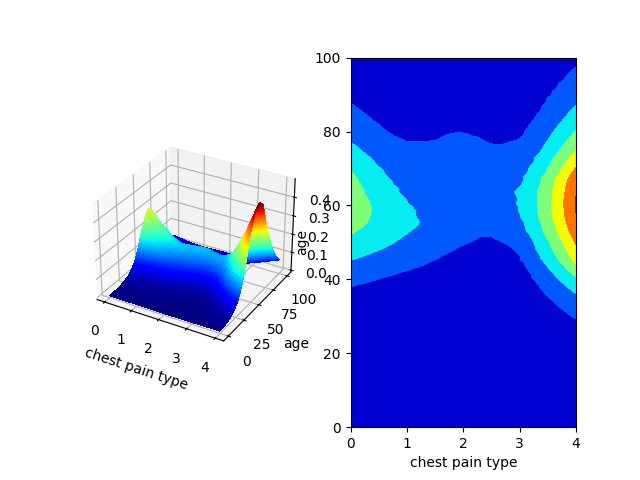

In [14]:
# Jaká je průměrná chyba predikce modelu na celém datasetu?

def mean_dataset_error_two_feature(dataset, model):
    '''
    Funkce pro výpočet hodnoty chybové funkce L1 pro lineární regresi na celém datasetu.
    '''
    model.eval()
    error_value = 0
    largest_error = 0
    for row in dataset.iloc:
        input_tensor = torch.cat((g_agepain_dataset_trn.normalize_age(row['age']), g_agepain_dataset_trn.one_hot_encode_cp(row['cp'])))

        prediction = model(input_tensor)

        error_value += abs(prediction.item() - row['target'])
    return error_value / len(dataset)

# Spočítáme chybu pro trénovací a validační dataset
g_age_pain_err_trn = mean_dataset_error_two_feature(g_dataframe_trn, g_age_pain_model)
g_age_pain_err_val = mean_dataset_error_two_feature(g_dataframe_val, g_age_pain_model)
g_model_errors["Two feature model"] = [g_age_pain_err_trn, g_age_pain_err_val]

# Znovu vytiskneme tabulku s výsledky
print_error_table(g_model_errors)

# Zobrazíme si model
display_two_feature_model(g_age_pain_model)


#Zkusíme natrénovat model na všech featurách
- Dvě featury jsou málo pro rozumné určení pravděpodobnosti nemoci - přidáme zbytek.


In [15]:
# Vytvoříme dataset s využitím všech featur
class AllFeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, data_info):
        self.dataframe = dataframe
        self.data_info = data_info
        self.thal_vals = {"fixed": [1, 0, 0],
                          "normal": [0, 1, 0],
                          "reversible": [0, 0, 1],
                          "0": [1, 0, 0],
                          "1": [0, 1, 0],
                          "2": [0, 0, 1]}

        self.stds = {}
        self.means = {}

        for feature in data_info:
            if g_data_info[feature]["type"] == "numerical":
                self.stds[feature] = self.dataframe[feature].std()
                self.means[feature] = self.dataframe[feature].mean()


    def __len__(self):
        return len(self.dataframe)

    def normalize_numerical(self, feature, value):
        '''
        Číselné featury opět znormalizujeme aby se pohybovala kolem 0.
        '''
        return (value - self.means[feature]) / self.stds[feature]

    def encode_categorical(self, feature, value):
        '''
        Kategorické featury opět převedeme na one hot encoding.
        '''
        one_hot = [0] * len(self.data_info[feature]["encoding"])
        one_hot[value] = 1
        return one_hot

    def __getitem__(self, idx):
        '''
        Funkce pro získání jednoho vzorku z datasetu. Tentokrát je vzorek složitější...
        '''
        row = self.dataframe.iloc[idx]
        features = []
        for feature in self.data_info:
            if feature == "target":
                continue
            elif feature == "thal":
                features += self.thal_vals[row[feature]]
            elif self.data_info[feature]["type"] == "numerical":
                features += [self.normalize_numerical(feature, row[feature])]
            else:
                features += self.encode_categorical(feature, row[feature])
        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(row["target"], dtype=torch.float32).unsqueeze(0)
        return features, target

# Vytvoření full feature datasetů pro validaci a trénování
g_dataset_full_val = AllFeaturesDataset(g_dataframe_val, g_data_info)
g_dataset_full_trn = AllFeaturesDataset(g_dataframe_trn, g_data_info)

# Jak vypadá jeden zakódovaný vzorek z datasetu
print(g_dataset_full_trn[0])

(tensor([ 0.8817,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.7231, -0.2982,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0720,
         1.0000,  0.0000,  1.0102,  0.0000,  0.0000,  0.0000,  1.0000, -0.7210,
         1.0000,  0.0000,  0.0000]), tensor([0.]))


# Natrénujeme model se všemi features

In [16]:
def train_all_fetures(model, dataset_trn, dataset_val, batch_size, epochs):

    # Vytvoření objektu "trenéra" z třídy L.Trainer
    trainer = L.Trainer(max_epochs=epochs)

    # Pomocné třídy na opakované vytahování batchů dat
    dataloader_trn = torch.utils.data.DataLoader(dataset_trn, batch_size=batch_size, drop_last=False, shuffle=True)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=61, drop_last=False)

    # Zde se teď skrývá trénovací smyčka
    trainer.fit(model=model,
                train_dataloaders=dataloader_trn,
                val_dataloaders=dataloader_val)

# Vytvoření modelu z naší třídy LModel
g_inputs_no = g_dataset_full_trn[0][0].shape[0]
g_model_full = LModel(inputs=g_inputs_no, hidden_units=32, lr=1e-3)

# Trénování modelu pro predikci s dvěmi features
train_all_fetures(g_model_full, g_dataset_full_trn, g_dataset_full_val, batch_size=32, epochs=40)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 929    | train
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=40` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


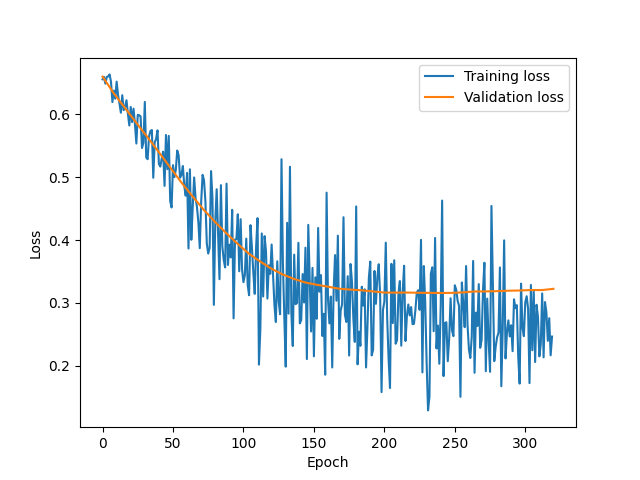

In [17]:
# Vykreslíme historii trénovacícho lossu
g_loss_history_full = g_model_full.trn_loss_history
g_val_loss_history_full = g_model_full.val_loss_history
val_x_axis_indices = np.linspace(0, len(g_loss_history_full), len(g_val_loss_history_full)).astype(int)

plt.close()
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(g_loss_history_full, label='Training loss')
ax.plot(val_x_axis_indices, g_val_loss_history_full, label='Validation loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

# Natrénovaný model - všechny featury

- Model je stále funkce, ale kvůli množství proměnných (featur) už nejde jednoduše zobrazit :(
- Porovnejme aspoň jeho chybovost



In [18]:
def mean_full_dataset_error(model, dataset):
    model.eval()
    error_function = torch.nn.L1Loss()
    error = 0

    for i in range(len(dataset)):
        x, y = dataset[i]
        y_hat = model(x)
        error += error_function(y_hat, y)

    return (error / len(dataset)).item()

# Spočítáme trénovací a validační chybu
g_error_full_trn = mean_full_dataset_error(g_model_full, g_dataset_full_trn)
g_error_full_val = mean_full_dataset_error(g_model_full, g_dataset_full_val)
g_model_errors["All features"] = [g_error_full_trn, g_error_full_val]

# Porovnáme chybovost všech modelů
print_error_table(g_model_errors)

+-------------------+--------------------+--------------------+---------------------+--------------------+
|       Model       |   Training error   |  Training error %  |   Validation error  | Validation error % |
+-------------------+--------------------+--------------------+---------------------+--------------------+
| One feature model | 0.3843514039989345 | 38.435140399893456 |  0.3771361450924248 | 37.71361450924248  |
|    Random guess   |        0.5         |        50.0        |  0.4918032786885246 | 49.18032786885246  |
| Two feature model | 0.3193979465194847 | 31.93979465194847  |  0.3396719660090863 | 33.96719660090863  |
|    All features   | 0.1748977154493332 | 17.48977154493332  | 0.21584783494472504 | 21.584783494472504 |
+-------------------+--------------------+--------------------+---------------------+--------------------+


# Závěr
- Zopakovali jsme si jednoduché matematické funkce a ukázali jsme si, jak použít derivaci pro optimalizaci parametrů funkce.
- Vyzkoušeli jsme si trénování několika jednoduchých modelů.
- Vyzkoušeli jsme knihovny Pytorch a Lightning pro trénování.
- Rozdělili jsme si dataset na trénovací a validační data.
- Ukázali jsme si, jak porovnávat modely mezi sebou.

Zapřemýšlejte, co se vám na cvičení líbilo a co zajímavého jste se dozvěděli :) Pokud jste nepochopili všechno, tak to vůbec nevadí! Můžete si uložit odkaz na materiály a projít si je znovu později.